In [63]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math

In [64]:
# Initial imports
df_data_all = pd.read_csv("data.csv")
df_data_all = df_data_all.set_index("symbol")

df_clinical_all = pd.read_csv("clinical_data.csv")
df_clinical_all = df_clinical_all.set_index("case_id")

cancer_types = list(set(df_clinical_all.primary_diagnosis))

columns = df_clinical_all.columns.values
print(columns)


['primary_diagnosis' 'primary_gleason_grade' 'figo_staging_edition_year'
 'updated_datetime' 'occupation_duration_years' 'ann_arbor_clinical_stage'
 'best_overall_response' 'largest_extrapelvic_peritoneal_focus'
 'esophageal_columnar_dysplasia_degree' 'perineural_invasion_present'
 'tissue_or_organ_of_origin' 'cog_liver_stage'
 'burkitt_lymphoma_clinical_variant' 'ajcc_clinical_m' 'igcccg_stage'
 'percent_tumor_invasion' 'ishak_fibrosis_score' 'diagnosis_id'
 'irs_stage' 'esophageal_columnar_metaplasia_present'
 'transglottic_extension' 'cog_neuroblastoma_risk_group'
 'last_known_disease_status' 'ajcc_clinical_n'
 'peritoneal_fluid_cytological_status' 'cog_renal_stage'
 'cog_rhabdomyosarcoma_risk_group' 'created_datetime' 'laterality'
 'days_to_last_known_disease_status' 'tumor_focality'
 'days_to_best_overall_response' 'tumor_largest_dimension_diameter'
 'gross_tumor_weight' 'greatest_tumor_dimension' 'lymph_nodes_tested'
 'supratentorial_localization' 'gleason_grade_group'
 'weiss_as

In [65]:
def get_data_by_cancer(cancer_type):
    '''
    Given a cancer type, return the RNA-seq and clinical DataFrames with only those entries 
    corresponding to that cancer type.
    '''
    df_clinical = df_clinical_all[df_clinical_all.primary_diagnosis == cancer_type]
    ids = df_clinical.index.values
    df_data = df_data_all[ids]
    return df_data, df_clinical

In [66]:
def get_library_size_df(df_data):
    return pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

In [67]:
def norm_and_zscore(df_data):
    # take 2500 top most variable rows
    df_data_norm = filter_by_var(df_data)

    # compute log normalization of matrix
    df_data_norm = np.log2(df_data_norm + 1)

    # convert to zscores
    df_data_norm = pd.DataFrame(zscore(df_data_norm, axis=0, ddof=0), 
                                index=df_data_norm.index, 
                                columns=df_data_norm.columns)
    
    return df_data_norm

In [68]:
def get_pca_df(df_data_norm):
    '''
    Perform PCA to reduce dimensionality of the dataset before clustering
    while stitll maintaining most of the variability
    '''
    data_norm_pca = PCA(
      random_state=42,
    )
    data_norm_pca.fit(df_data_norm.values.T)
    df_data_norm_pca = pd.DataFrame(
        data_norm_pca.transform(df_data_norm.values.T),
        index=df_data_norm.T.index
    )
    df_data_norm_pca.columns = [
        f'PCA-{c}' # ({r:.3f})'
        for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
    ]
    return df_data_norm_pca

In [77]:
def get_umap_df(df_data_norm_pca):
    '''
    UMAP: Uniform Manifold Approximation and Projection (UMAP) dimensional reduction technique
    arguments here are defaults in Seurat, considered the standard
    '''
    n_neighbors = 30
    if (len(df_data_norm_pca.columns) < 30): # in case the dataset is small
        n_neighbors = math.floor(len(df_data_norm_pca.columns) / 10.) + 2 # must be > 1
    data_norm_umap = UMAP(
      random_state=42,
      n_components=2,
      n_neighbors=n_neighbors,
      metric='cosine',
      min_dist=0.3,
    )

    # use top 10 components of PCA
    data_norm_umap.fit(df_data_norm_pca.iloc[:, :10].values)

    df_data_norm_umap = pd.DataFrame(
      data_norm_umap.transform(df_data_norm_pca.iloc[:, :10].values),
      columns=['UMAP-1', 'UMAP-2'],
      index=df_data_norm_pca.index,
    )
    return df_data_norm_umap
    

In [81]:
def compute_silhouette_scores(df_data_norm_umap):
    '''
    Compute silhouette scores, which are a measure of how similar an entry is to its 
    cluster; from this, we can decide the ideal number of clusters
    '''
    silhouette_scores = {}
    
    max_clusters = 25
    if (df_data_norm_umap.shape[0] < 25):
        max_clusters = df_data_norm_umap.shape[0]
        max_clusters = max(3,max_clusters)
        
    for n in range(2, max_clusters):
        y_pred = KMeans(n_clusters=n, random_state=42).fit_predict(df_data_norm_umap.values)
        silhouette_scores[n] = silhouette_score(df_data_norm_umap.values, y_pred, metric='cosine')
    silhouette_scores = pd.DataFrame([
        {'N Clusters': k, 'Silhouette Score': v}
        for k, v in silhouette_scores.items()
    ])
    best = silhouette_scores.sort_values('Silhouette Score').iloc[-1]
    return silhouette_scores, best

In [71]:
def get_data_norm_km_df(df_data_norm_umap, best_silhouette_score):
    '''
    Compute the Kmeans dataframe
    '''
    km = KMeans(n_clusters=int(best_silhouette_score['N Clusters']), random_state=42)
    df_data_norm_km = pd.DataFrame({
    'Cluster': [
        str(c)
        for c in km.fit_predict(df_data_norm_umap.values)
    ]}, index=df_data_norm_umap.index)

    return df_data_norm_km

In [72]:
def get_diff_expr_df(df_data_norm, df_data_norm_km):
    '''
    Perform differential expression for each cluter
    '''
    diff_expr = {}
    for cluster, samples in df_data_norm_km.groupby('Cluster'):
        diff_expr[cluster] = characteristic_direction(
            # expression outside of this cluster
            df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
            # expression in this cluster
            df_data_norm.loc[:, samples.index],
          )['CD-coefficient']

    df_diff_expr = pd.DataFrame(diff_expr)

    df_diff_expr.index.name = 'Feature Name'
    return df_diff_expr['0'].sort_values(ascending=True)

In [131]:
def compute_lr_aucs(df_data_norm_km, df_clinical):
    '''
    Fit a logistic regression on each feature to see which most accurately predict
    cluster
    '''
    aucs = {}
    #df_clinical = df_clinical.drop(columns=["primary_diagnosis"])
    for cluster, samples in df_data_norm_km.groupby('Cluster'): 
        aucs[cluster] = {}

        for feature in df_clinical.columns: # TODO: drop NAs
            lr = LogisticRegression()
            X = df_clinical.copy()
            X = X[feature]
            X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)
            
            # drop NAs, and move on if dataset is empty
            X.replace("not reported", None)
            X = X.dropna()
            if (X.shape[0] == 0): continue

            cluster_data = X["Cluster"]
            X = X.drop(columns= ["Cluster"])
            
            # one-hot encode non numerical data
            if (not isinstance(X[feature][0], (int, float, complex))):
                X = pd.get_dummies(X[feature], prefix=feature)

            y_true = (cluster_data == cluster)

            if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
            lr.fit(X, y_true)
            y_score = lr.predict_proba(X)[:, 1]
            aucs[cluster][feature] = roc_auc_score(y_true, y_score)
    return pd.DataFrame(aucs)

In [144]:
def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)

    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/10_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/10_components/projection.csv')
    
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
    
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')

,n_reads,log_n_reads,n_expressed_genes
3b076d77-6276-4233-867b-6a10d9e17343,18663,14.187971,54333296
3b076d77-6276-4233-867b-6a10d9e17343,18663,14.187971,54333296
7ab5a708-803f-4d8c-9b25-645f06851a26,18586,14.182006,42783967
a6635058-4498-463c-9bbc-1009dda3308c,18577,14.181308,43117857
f89ac782-e0b2-4e62-844d-2e00d10a1c65,18492,14.174692,60527602


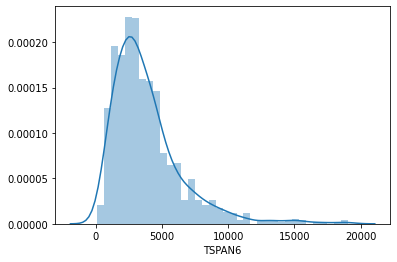

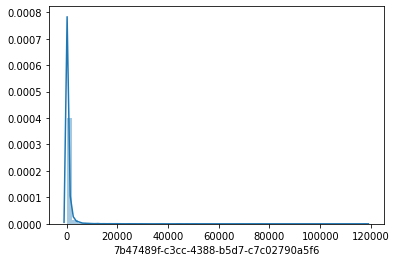

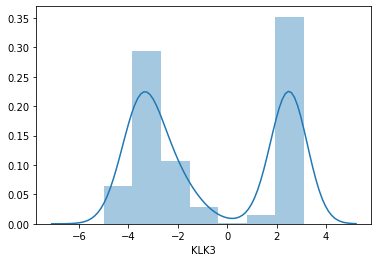

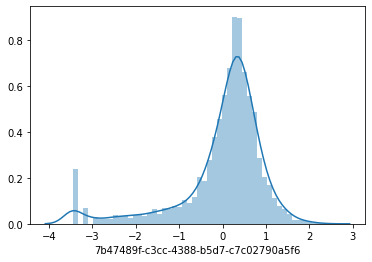

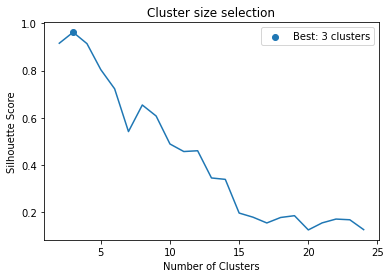

In [145]:
for cancer in cancer_types:
    df_data, df_clinical = get_data_by_cancer(cancer)
    
    # if only one entry, move on to next type (no clustering can be done)
    if (len(df_clinical.index.values) < 2): continue
    
    #%% initial stastistics
    df_library_size = get_library_size_df(df_data)
    # plots
    display(df_library_size.head())
    # distribution among all samples of reads for first gene in dataset
    sns.distplot(df_data.iloc[0, :]); plt.show() 
    # distribution among first sample of all reads
    sns.distplot(df_data.iloc[:, 0]); plt.show()

    #%% normalize
    df_data_norm = norm_and_zscore(df_data)
    # plot
    sns.distplot(df_data_norm.iloc[0, :]); plt.show()
    sns.distplot(df_data_norm.iloc[:, 0]); plt.show()
    
    #%% pca
    df_data_norm_pca = get_pca_df(df_data_norm)
    # plot
    feature = "gender"
    fig = px.scatter(
      merge(
        df_data_norm_pca,
        df_library_size,
        df_clinical
      ),
      x=df_data_norm_pca.columns[0],
      y=df_data_norm_pca.columns[1],
      size='n_reads',
      size_max=8,
      color=feature,
      hover_name=feature,
      hover_data=["ethnicity"],
    )
    fig.show()
    
    #%% umap
    df_data_norm_umap = get_umap_df(df_data_norm_pca)
    # plot
    feature = "gender"
    px.scatter(
      merge(
        df_data_norm_umap,
        df_library_size,
        df_clinical
      ),
      x=df_data_norm_umap.columns[0],
      y=df_data_norm_umap.columns[1],
      size='n_reads',
      size_max=8,
      color=feature,
      hover_name=feature,
      hover_data=["ethnicity"],
    )


    #%% silhouette scores
    silhouette_scores, best = compute_silhouette_scores(df_data_norm_umap)
    # plot
    plt.plot(silhouette_scores['N Clusters'], silhouette_scores['Silhouette Score'])
    plt.scatter([best['N Clusters']], [best['Silhouette Score']], label='Best: {} clusters'.format(int(best["N Clusters"])))
    plt.legend()
    plt.title('Cluster size selection')
    plt.ylabel('Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.show()
    
    df_data_norm_km = get_data_norm_km_df(df_data_norm_umap, best)
    
    #%% differential expression
    df_diff_expr = get_diff_expr_df(df_data_norm, df_data_norm_km)
    
    #%% LR performance
    df_aucs = compute_lr_aucs(df_data_norm_km, df_clinical)
    
    #%%
    save_data(cancer,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs)
  